In [1]:
import os
import torch
import torch.nn as nn
import torchvision 
from torch.nn import Linear
from torch import optim
import pandas as pd
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from mpl_toolkits import mplot3d
%matplotlib inline
torch.set_printoptions(threshold=50,edgeitems=300,linewidth=100)
import math
import statistics 
import optuna
import plotly
torch.set_default_dtype(torch.float64)
import jovian
import torchvision.transforms


In [2]:
torch.cuda.is_available()

True

In [3]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
    
torch.cuda.device_count()


Running on the GPU


1

In [4]:
coord_all = np.load("/home/sneha/Downloads/files/03_Kreuznapf/coord_all_81000001.npy")
disp_all = np.load("/home/sneha/Downloads/files/03_Kreuznapf/disp_all_81000001.npy")


In [5]:

disp_all = torch.tensor(disp_all, dtype=torch.float64)

print(disp_all.shape)
print(torch.min(disp_all))
print(torch.max(disp_all))
print(torch.mean(disp_all) )
Norm = torchvision.transforms.Normalize((disp_all[:,:,0].mean(),disp_all[:,:,1].mean(),disp_all[:,:,2].mean()),(disp_all[:,:,0].std(),disp_all[:,:,1].std(),disp_all[:,:,2].std()))
disp_all = Norm(disp_all.T).T

print(disp_all.shape)
print(torch.min(disp_all))
print(torch.max(disp_all))
print(torch.mean(disp_all))

torch.Size([249, 4981, 3])
tensor(-138.5823)
tensor(159.2684)
tensor(-7.7699)
torch.Size([249, 4981, 3])
tensor(-3.1509)
tensor(2.6380)
tensor(9.3130e-17)


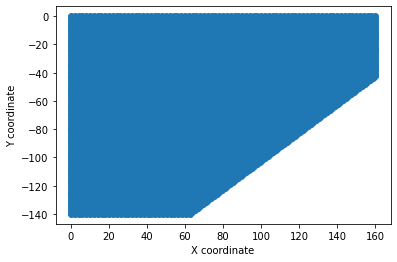

In [6]:
exp = 5
fig = plt.figure()
xi = coord_all[exp,:,0]
yi = coord_all[exp,:,1]
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.scatter(xi,yi)
plt.show() 

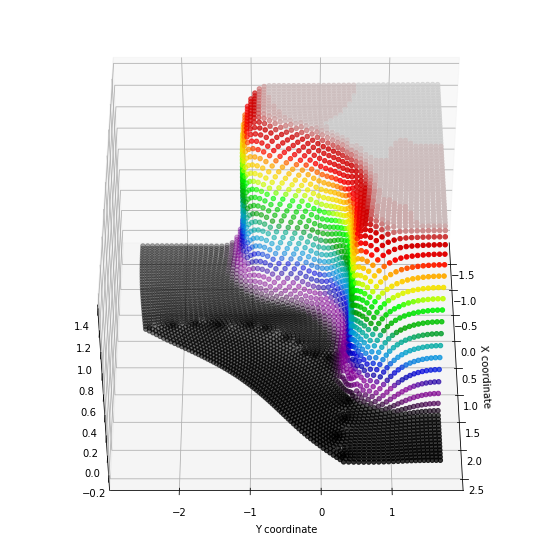

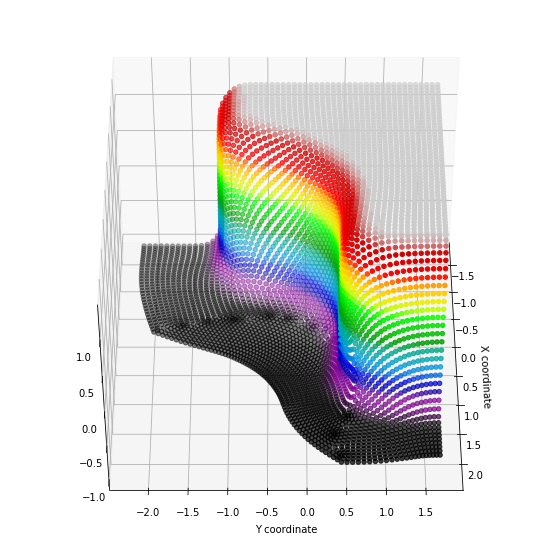

In [7]:
for exp in range(2):
    fig = plt.figure(figsize=(10,10))
    xi = disp_all[exp,:,0]
    yi = disp_all[exp,:,1]
    zi = disp_all[exp,:,2]
    ax = fig.add_subplot(projection='3d')
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    ax.scatter3D(xi, yi, zi, c=zi, cmap='nipy_spectral')
    ax.view_init(elev=45,azim=0)
    plt.show()
    
    
    #(np.random.randint(1,249,10))

### Data Processing

In [8]:
from torch.utils.data import Dataset, DataLoader
   


class Dataset(Dataset):
    def __init__(self): #transform=None
        super(Dataset,self).__init__()
        
        ## here you can add the file path
        self.data_name=pd.read_csv('/home/sneha/Downloads/files/03_Kreuznapf/Experiments_1_without_Error_Term.csv', sep=';', decimal=',')
        self.x = torch.tensor(self.data_name[['F_press','fs','h_BT']].values, dtype = torch.float64)
        print(self.data_name.head())
        print("size of input is ",self.x.size())

        #Output
        disp_all = np.load("/home/sneha/Downloads/files/03_Kreuznapf/disp_all_81000001.npy")
        disp_all = torch.tensor(disp_all, dtype=torch.float64)
        Norm = torchvision.transforms.Normalize((disp_all[:,:,0].mean(),disp_all[:,:,1].mean(),disp_all[:,:,2].mean()),(disp_all[:,:,0].std(),disp_all[:,:,1].std(),disp_all[:,:,2].std()))
        disp_all = Norm(disp_all.T).T
        print(disp_all[0,0:10])
        self.y = torch.hstack((disp_all[:,:,0],disp_all[:,:,1],disp_all[:,:,2]))
        print(self.y.size())
        print(self.y[0,0:10])
        print("size of output is \n",self.y.size())
        self.len = self.x.shape[0]
        
    def __len__(self):
        return self.len
     
    def __getitem__(self, index):

        return self.x[index],self.y[index]
    
data = Dataset()


   Point       F_press        fs       h_BT
0      1  240000.00000  0.100000  45.000000
1      2  124271.08430  0.113554  61.656627
2      3  274214.85940  0.114157  67.981928
3      4  164640.56220  0.196084  50.552209
4      5   73809.23695  0.129217  61.094378
size of input is  torch.Size([249, 3])
tensor([[ 2.3755,  1.6843, -0.2108],
        [-1.6395,  1.6843,  1.3387],
        [-1.5849,  1.6843,  1.3399],
        [-1.5304,  1.6843,  1.3398],
        [-1.4759,  1.6843,  1.3393],
        [-1.4214,  1.6843,  1.3389],
        [-1.3669,  1.6843,  1.3385],
        [-1.3124,  1.6843,  1.3381],
        [-1.2578,  1.6843,  1.3377],
        [-1.2032,  1.6843,  1.3374]])
torch.Size([249, 14943])
tensor([ 2.3755, -1.6395, -1.5849, -1.5304, -1.4759, -1.4214, -1.3669, -1.3124, -1.2578, -1.2032])
size of output is 
 torch.Size([249, 14943])


### splitting data into train and vaidation

In [9]:
val_size = 50
train_size = len(data) - val_size
train_ds, val_ds = random_split(data, [train_size, val_size])
print("the train size is {} and validation size is {} ".format(len(train_ds), len(val_ds)))

batch_size = 249
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size) 


the train size is 199 and validation size is 50 


### Defining the Model
https://www.coursera.org/learn/deep-neural-networks-with-pytorch/home/welcome

In [10]:
class My_Model(nn.Module):
    def __init__(self, in_size, h,s,outsize, p=0):
        
        super(My_Model,self). __init__()
        self.in_size = in_size
        self.outsize = outsize
        self.h = h
        self.s = s
        self.hidden=nn.ModuleList()
        self.drop=nn.Dropout(p=p)
        self.Layers = [in_size, *[self.s for i in range(h)], outsize]
        print(self.Layers)
        self.norm = nn.BatchNorm1d(s)
        for input_size,output_size in zip(self.Layers, self.Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
            
    def forward(self, activation):
        L=len(self.hidden)
        for(l,linear_transform) in zip(range(L),self.hidden):
            if l<L-1:
            
                activation = linear_transform(activation)
                activation=torch.relu(self.norm(activation))
                activation=self.drop(activation)
            else:
                activation= linear_transform(activation)
        return activation

In [11]:
from torch_lr_finder import LRFinder

def lrfinder(model):
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3)
    lr_finder = LRFinder(model, optimizer, MSE, device=device)
    lr_finder.range_test(train_loader, end_lr=100, num_iter=50)
    lr_finder.reset() # to reset the model and optimizer to their initial state
    ax, lr = lr_finder.plot() # to inspect the loss-learning rate graph
    return lr


### Training
https://www.coursera.org/learn/deep-neural-networks-with-pytorch/home/welcome

In [12]:


def train(model,train_loader, val_loader, optimizer, epochs):
    model.to(device)
    total_loss = {'training_loss':[],'validation_loss':[]}
    for epoch in range(epochs):
        batch_loss=[]
        for i,(x,y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            yhat = model(x)
            loss = MSE(y,yhat)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss.append(torch.sqrt(loss).item())
        total_loss['training_loss'].append(torch.Tensor(batch_loss).mean().item())
#         print(total_loss['training_loss'])
  
        with torch.no_grad():
            model.eval()
            batch_loss=[]        
            for x,y in val_loader:
                x = x.to(device)
                y = y.to(device)
                yhat = model(x)
                loss = MSE(y,yhat)
                batch_loss.append(torch.sqrt(loss).item())
            total_loss['validation_loss'].append(torch.Tensor(batch_loss).mean().item()) 
#             print(total_loss['validation_loss'])

        #if total_loss['training_loss'][epoch]>total_loss['training_loss'][epoch-1] and total_loss['validation_loss'][epoch]>total_loss['validation_loss'][epoch-1]:
            #break
    return total_loss


### Calculate R squared score

In [13]:
from sklearn.metrics import r2_score

def r2score(model):
    x = data[:][0].to(device)
    y = data[:][1].detach().to(device)
    yhat= model(x).detach().to(device)
    r2_score= 1- (torch.sum((y-yhat)**2)/torch.sum((y-y.float().mean())**2))
    print("R squared score is",r2_score)
    return r2_score.item()


### Training and Validation loss vs epochs

ValueError: x and y must have same first dimension, but have shapes (30,) and (60,)

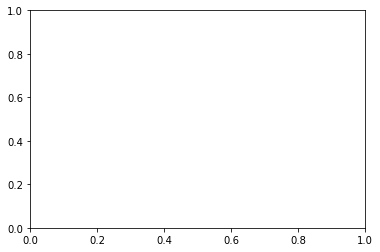

In [18]:
epochs = 30
epochs = range(1,epochs+1)
plt.plot(epochs, total_loss['training_loss'], 'g', label='Training loss')
plt.plot(epochs, total_loss['validation_loss'], 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### to find the best hyperparameters from OPTUNA
https://optuna.readthedocs.io/en/stable/tutorial/index.html

In [30]:
MSE = nn.MSELoss()

def objective(trial):
    epochs = 30
    in_size = 3 
    outsize = 14943
    h = trial.suggest_int("n_layers", 1,7)
    print(h)
    p = trial.suggest_float("n_units_l{}".format(h),0.2,0.5)
    print(p)
    s = trial.suggest_int("hidden layer size",400,1000)
    torch.manual_seed(849454)
    model = My_Model(in_size, h,s,outsize, p).to(device)
    print(model)
    lrfder = trial.suggest_float("lr",1e-5,1e-1)
    print(lrfder)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop","SGD"])
    print(optimizer_name)
    optimizer = getattr(optim,optimizer_name)(model.parameters(), lr=lrfder)# weight_decay= 1e-3
    total_loss= train(model,train_loader, val_loader, optimizer, epochs)

    for training_loss,validation_loss in zip(total_loss['training_loss'],total_loss['validation_loss']):
        print('training_loss:{:.2f},     validation_loss:{:.2f}'.format(training_loss,validation_loss))
    trial.report(total_loss['validation_loss'][-1], epochs)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return total_loss['validation_loss'][-1]
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective,n_trials=100, timeout = 150)
    
    pruned_trials = [t for t in study.trials if t.state ==optuna.trial.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state ==optuna.trial.TrialState.PRUNED]
    

if torch.cuda.is_available():
    torch.cuda.empty_cache()

[I 2021-03-10 13:22:28,744] A new study created in memory with name: no-name-f4020bd9-da0e-4305-a7ad-70ca0165074c


1
0.41379787174388366
[3, 500, 14943]
My_Model(
  (hidden): ModuleList(
    (0): Linear(in_features=3, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=14943, bias=True)
  )
  (drop): Dropout(p=0.41379787174388366, inplace=False)
  (norm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
0.04330398148556553
RMSprop


[I 2021-03-10 13:22:34,318] Trial 0 finished with value: 0.9190572000139142 and parameters: {'n_layers': 1, 'n_units_l1': 0.41379787174388366, 'hidden layer size': 500, 'lr': 0.04330398148556553, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.9190572000139142.


training_loss:1.12,     validation_loss:15301.96
training_loss:11193.03,     validation_loss:1.10
training_loss:1.08,     validation_loss:1.02
training_loss:1.00,     validation_loss:0.98
training_loss:0.96,     validation_loss:0.96
training_loss:0.94,     validation_loss:0.94
training_loss:0.93,     validation_loss:0.94
training_loss:0.92,     validation_loss:0.93
training_loss:0.92,     validation_loss:0.93
training_loss:0.92,     validation_loss:0.93
training_loss:0.91,     validation_loss:0.93
training_loss:0.91,     validation_loss:0.93
training_loss:0.91,     validation_loss:0.92
training_loss:0.91,     validation_loss:0.92
training_loss:0.91,     validation_loss:0.92
training_loss:0.91,     validation_loss:0.92
training_loss:0.91,     validation_loss:0.92
training_loss:0.91,     validation_loss:0.92
training_loss:0.91,     validation_loss:0.92
training_loss:0.91,     validation_loss:0.92
training_loss:0.91,     validation_loss:0.92
training_loss:0.91,     validation_loss:0.92
tr

[I 2021-03-10 13:22:40,244] Trial 1 finished with value: 0.32941884715313674 and parameters: {'n_layers': 6, 'n_units_l6': 0.44841226767286047, 'hidden layer size': 417, 'lr': 0.040669153690129745, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.32941884715313674.


training_loss:1.14,     validation_loss:8.54
training_loss:8.54,     validation_loss:1.05
training_loss:1.04,     validation_loss:0.97
training_loss:0.96,     validation_loss:0.92
training_loss:0.91,     validation_loss:0.88
training_loss:0.87,     validation_loss:0.84
training_loss:0.83,     validation_loss:0.80
training_loss:0.79,     validation_loss:0.77
training_loss:0.76,     validation_loss:0.74
training_loss:0.72,     validation_loss:0.71
training_loss:0.69,     validation_loss:0.68
training_loss:0.66,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.60
training_loss:0.58,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.53
training_loss:0.51,     validation_loss:0.51
training_loss:0.49,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.44
training_l

[I 2021-03-10 13:22:46,675] Trial 2 finished with value: 1.007531689350034 and parameters: {'n_layers': 7, 'n_units_l7': 0.3681616609956587, 'hidden layer size': 471, 'lr': 0.0270226186163325, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.32941884715313674.


training_loss:1.12,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_l

[I 2021-03-10 13:22:52,337] Trial 3 finished with value: 1.0076021245387956 and parameters: {'n_layers': 2, 'n_units_l2': 0.4744517415121046, 'hidden layer size': 503, 'lr': 0.042850934462636346, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.32941884715313674.


training_loss:1.15,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_l

[I 2021-03-10 13:22:58,918] Trial 4 finished with value: 0.25847946232316743 and parameters: {'n_layers': 6, 'n_units_l6': 0.40509642160938253, 'hidden layer size': 455, 'lr': 0.09176460461207694, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.25847946232316743.


training_loss:1.13,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.49
training_loss:0.46,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.32
training_loss:0.29,     validation_loss:0.36
training_loss:0.34,     validation_loss:0.42
training_loss:0.41,     validation_loss:0.39
training_loss:0.37,     validation_loss:0.33
training_loss:0.31,     validation_loss:0.33
training_loss:0.32,     validation_loss:0.36
training_loss:0.34,     validation_loss:0.31
training_loss:0.30,     validation_loss:0.26
training_loss:0.24,     validation_loss:0.27
training_loss:0.24,     validation_loss:0.30
training_loss:0.28,     validation_loss:0.29
training_loss:0.26,     validation_loss:0.26
training_loss:0.24,     validation_loss:0.28
training_loss:0.25,     validation_loss:0.30
training_loss:0.27,     validation_loss:0.29
training_loss:0.26,     validation_loss:0.26
training_loss:0.23,     validation_loss:0.27
training_loss:0.24,     validation_loss:0.28
training_l

[I 2021-03-10 13:23:05,379] Trial 5 pruned. 


training_loss:1.15,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_l

[I 2021-03-10 13:23:16,781] Trial 6 pruned. 


training_loss:1.13,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_loss:1.00,     validation_loss:1.01
training_l

[I 2021-03-10 13:23:31,924] Trial 7 finished with value: 0.2408791997097794 and parameters: {'n_layers': 7, 'n_units_l7': 0.3333900129952869, 'hidden layer size': 912, 'lr': 0.006094046501061345, 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.2408791997097794.


training_loss:1.12,     validation_loss:0.65
training_loss:0.63,     validation_loss:0.40
training_loss:0.38,     validation_loss:0.34
training_loss:0.32,     validation_loss:0.28
training_loss:0.25,     validation_loss:0.27
training_loss:0.24,     validation_loss:0.25
training_loss:0.22,     validation_loss:0.25
training_loss:0.22,     validation_loss:0.25
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_l

[I 2021-03-10 13:23:40,606] Trial 8 finished with value: 0.26623864359355787 and parameters: {'n_layers': 2, 'n_units_l2': 0.2693721486743876, 'hidden layer size': 741, 'lr': 0.09517083921305322, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.2408791997097794.


training_loss:1.11,     validation_loss:0.52
training_loss:0.50,     validation_loss:0.35
training_loss:0.32,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.29
training_loss:0.26,     validation_loss:0.49
training_loss:0.48,     validation_loss:0.34
training_loss:0.32,     validation_loss:0.39
training_loss:0.37,     validation_loss:0.40
training_loss:0.39,     validation_loss:0.27
training_loss:0.24,     validation_loss:0.39
training_loss:0.37,     validation_loss:0.32
training_loss:0.30,     validation_loss:0.27
training_loss:0.25,     validation_loss:0.36
training_loss:0.35,     validation_loss:0.27
training_loss:0.24,     validation_loss:0.30
training_loss:0.28,     validation_loss:0.34
training_loss:0.31,     validation_loss:0.25
training_loss:0.23,     validation_loss:0.31
training_loss:0.29,     validation_loss:0.30
training_loss:0.27,     validation_loss:0.25
training_loss:0.22,     validation_loss:0.30
training_loss:0.28,     validation_loss:0.27
training_l

[I 2021-03-10 13:23:48,863] Trial 9 finished with value: 0.24098780954859328 and parameters: {'n_layers': 2, 'n_units_l2': 0.22159569765346532, 'hidden layer size': 687, 'lr': 0.07379294923841456, 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.2408791997097794.


training_loss:1.10,     validation_loss:48.62
training_loss:48.49,     validation_loss:1.02
training_loss:1.01,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.59
training_loss:0.57,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.25
training_loss:0.22,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training

[I 2021-03-10 13:24:02,347] Trial 10 finished with value: 0.24098356320831357 and parameters: {'n_layers': 4, 'n_units_l4': 0.2648620594598465, 'hidden layer size': 994, 'lr': 0.00210950095808847, 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.2408791997097794.


training_loss:1.10,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.43
training_loss:0.41,     validation_loss:0.32
training_loss:0.29,     validation_loss:0.28
training_loss:0.25,     validation_loss:0.26
training_loss:0.23,     validation_loss:0.26
training_loss:0.22,     validation_loss:0.25
training_loss:0.22,     validation_loss:0.25
training_loss:0.22,     validation_loss:0.25
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_l

[I 2021-03-10 13:24:15,984] Trial 11 finished with value: 0.24097110340244718 and parameters: {'n_layers': 4, 'n_units_l4': 0.25304867184361673, 'hidden layer size': 992, 'lr': 0.01109965146477666, 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.2408791997097794.


training_loss:1.11,     validation_loss:1.02
training_loss:1.01,     validation_loss:0.78
training_loss:0.77,     validation_loss:0.50
training_loss:0.49,     validation_loss:0.28
training_loss:0.26,     validation_loss:0.25
training_loss:0.22,     validation_loss:0.25
training_loss:0.22,     validation_loss:0.25
training_loss:0.22,     validation_loss:0.25
training_loss:0.22,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_l

[I 2021-03-10 13:24:27,866] Trial 12 finished with value: 0.24090811895196168 and parameters: {'n_layers': 4, 'n_units_l4': 0.20576541585709596, 'hidden layer size': 855, 'lr': 0.002889055771670573, 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.2408791997097794.


training_loss:1.10,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.42
training_loss:0.39,     validation_loss:0.31
training_loss:0.28,     validation_loss:0.28
training_loss:0.24,     validation_loss:0.26
training_loss:0.23,     validation_loss:0.25
training_loss:0.22,     validation_loss:0.25
training_loss:0.22,     validation_loss:0.25
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_l

[I 2021-03-10 13:24:40,696] Trial 13 pruned. 


training_loss:1.11,     validation_loss:0.96
training_loss:0.95,     validation_loss:0.94
training_loss:0.93,     validation_loss:0.93
training_loss:0.91,     validation_loss:0.91
training_loss:0.90,     validation_loss:0.89
training_loss:0.88,     validation_loss:0.87
training_loss:0.86,     validation_loss:0.86
training_loss:0.85,     validation_loss:0.84
training_loss:0.83,     validation_loss:0.83
training_loss:0.81,     validation_loss:0.81
training_loss:0.80,     validation_loss:0.79
training_loss:0.78,     validation_loss:0.78
training_loss:0.77,     validation_loss:0.77
training_loss:0.75,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.74
training_loss:0.72,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.70
training_loss:0.68,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.66
training_loss:0.64,     validation_loss:0.65
training_l

[I 2021-03-10 13:24:55,129] Trial 14 finished with value: 0.24130387590513927 and parameters: {'n_layers': 7, 'n_units_l7': 0.21196513145261422, 'hidden layer size': 866, 'lr': 0.017636186674074683, 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.2408791997097794.


training_loss:1.10,     validation_loss:3.63
training_loss:3.62,     validation_loss:1.01
training_loss:1.00,     validation_loss:0.92
training_loss:0.91,     validation_loss:0.86
training_loss:0.85,     validation_loss:0.79
training_loss:0.78,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.58
training_loss:0.56,     validation_loss:0.50
training_loss:0.49,     validation_loss:0.43
training_loss:0.41,     validation_loss:0.37
training_loss:0.34,     validation_loss:0.32
training_loss:0.29,     validation_loss:0.28
training_loss:0.26,     validation_loss:0.26
training_loss:0.23,     validation_loss:0.25
training_loss:0.22,     validation_loss:0.25
training_loss:0.22,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_l

[I 2021-03-10 13:25:08,618] Trial 15 finished with value: 0.24116565382496657 and parameters: {'n_layers': 5, 'n_units_l5': 0.48295939814904454, 'hidden layer size': 876, 'lr': 0.023912587164622606, 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.2408791997097794.


training_loss:1.14,     validation_loss:2.76
training_loss:2.75,     validation_loss:1.02
training_loss:1.01,     validation_loss:0.90
training_loss:0.89,     validation_loss:0.82
training_loss:0.81,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.69
training_loss:0.67,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.40
training_loss:0.38,     validation_loss:0.34
training_loss:0.32,     validation_loss:0.30
training_loss:0.27,     validation_loss:0.27
training_loss:0.24,     validation_loss:0.26
training_loss:0.23,     validation_loss:0.25
training_loss:0.22,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_loss:0.21,     validation_loss:0.24
training_l

In [31]:
print("study statistics")
print("number of finished trials:", len(study.trials))
print("number of pruned trials:", len(pruned_trials))
print("number of complete trials:", len(complete_trials))

print("best trials:")
trial = study.best_trial
print("Value:", trial.values)

print("param:")
for key,value in trial.params.items():
    print("{}:{}".format(key,value))

study statistics
number of finished trials: 16
number of pruned trials: 3
number of complete trials: 3
best trials:
Value: [0.2408791997097794]
param:
n_layers:7
n_units_l7:0.3333900129952869
hidden layer size:912
lr:0.006094046501061345
optimizer:RMSprop


In [25]:
optuna.visualization.plot_intermediate_values(study)

In [24]:
optuna.visualization.plot_slice(study)

### Initialisation

In [39]:
seed_list = np.array([9,89,232,5688,87843,216848,9867985,65468935,135878968,9999999999])
r2_score = np.zeros((7,10))
epochs = 30
in_size = 3 
outsize = 14943
s = 526

### Hyperparameter tuning


 hidden layer = 1 seed = 9
[3, 526, 14943]


Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-02


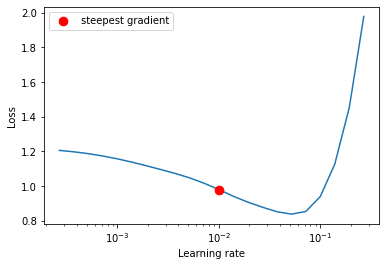

training_loss:1.11,     validation_loss:65.43
training_loss:47.75,     validation_loss:16.55
training_loss:12.03,     validation_loss:102.43
training_loss:74.97,     validation_loss:27.95
training_loss:20.34,     validation_loss:13.61
training_loss:9.87,     validation_loss:4.36
training_loss:3.14,     validation_loss:6.67
training_loss:4.99,     validation_loss:6.90
training_loss:5.06,     validation_loss:1.84
training_loss:1.35,     validation_loss:1.34
training_loss:1.04,     validation_loss:1.44
training_loss:1.09,     validation_loss:0.98
training_loss:0.73,     validation_loss:0.74
training_loss:0.64,     validation_loss:0.90
training_loss:0.65,     validation_loss:0.66
training_loss:0.59,     validation_loss:0.83
training_loss:0.59,     validation_loss:0.64
training_loss:0.59,     validation_loss:0.76
training_loss:0.54,     validation_loss:0.62
training_loss:0.58,     validation_loss:0.70
training_loss:0.51,     validation_loss:0.60
training_loss:0.57,     validation_loss:0.67


Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-02


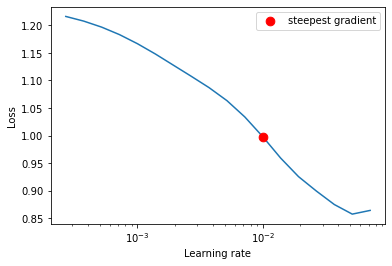

training_loss:1.11,     validation_loss:210.41
training_loss:153.84,     validation_loss:25.15
training_loss:18.26,     validation_loss:17.24
training_loss:12.49,     validation_loss:10.34
training_loss:7.45,     validation_loss:6.98
training_loss:5.21,     validation_loss:9.99
training_loss:7.27,     validation_loss:1.70
training_loss:1.50,     validation_loss:0.99
training_loss:0.78,     validation_loss:0.74
training_loss:0.64,     validation_loss:0.70
training_loss:0.58,     validation_loss:0.63
training_loss:0.54,     validation_loss:0.61
training_loss:0.51,     validation_loss:0.57
training_loss:0.48,     validation_loss:0.55
training_loss:0.44,     validation_loss:0.53
training_loss:0.43,     validation_loss:0.51
training_loss:0.40,     validation_loss:0.50
training_loss:0.40,     validation_loss:0.49
training_loss:0.38,     validation_loss:0.54
training_loss:0.45,     validation_loss:0.64
training_loss:0.53,     validation_loss:0.79
training_loss:0.75,     validation_loss:0.83
t

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-02


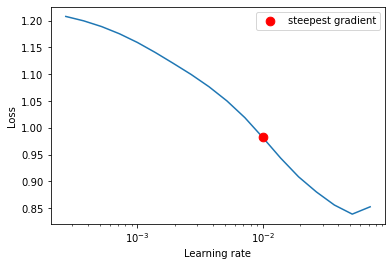

training_loss:1.11,     validation_loss:53.72
training_loss:39.18,     validation_loss:13.02
training_loss:9.48,     validation_loss:4.72
training_loss:3.48,     validation_loss:4.84
training_loss:3.54,     validation_loss:2.00
training_loss:1.54,     validation_loss:1.25
training_loss:0.96,     validation_loss:2.24
training_loss:1.71,     validation_loss:1.38
training_loss:1.06,     validation_loss:1.75
training_loss:1.37,     validation_loss:0.61
training_loss:0.52,     validation_loss:0.67
training_loss:0.59,     validation_loss:0.46
training_loss:0.40,     validation_loss:0.62
training_loss:0.56,     validation_loss:0.40
training_loss:0.35,     validation_loss:0.68
training_loss:0.65,     validation_loss:0.42
training_loss:0.39,     validation_loss:0.73
training_loss:0.71,     validation_loss:0.37
training_loss:0.34,     validation_loss:0.61
training_loss:0.58,     validation_loss:0.36
training_loss:0.32,     validation_loss:0.52
training_loss:0.49,     validation_loss:0.36
trainin

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-02


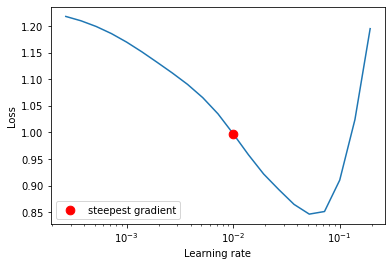

training_loss:1.11,     validation_loss:90.02
training_loss:65.74,     validation_loss:20.95
training_loss:15.23,     validation_loss:9.80
training_loss:7.12,     validation_loss:4.91
training_loss:3.58,     validation_loss:3.94
training_loss:2.89,     validation_loss:2.21
training_loss:1.70,     validation_loss:2.83
training_loss:2.07,     validation_loss:0.84
training_loss:0.75,     validation_loss:1.02
training_loss:0.87,     validation_loss:0.56
training_loss:0.52,     validation_loss:0.65
training_loss:0.57,     validation_loss:0.46
training_loss:0.42,     validation_loss:0.51
training_loss:0.45,     validation_loss:0.44
training_loss:0.37,     validation_loss:0.54
training_loss:0.48,     validation_loss:0.45
training_loss:0.37,     validation_loss:0.78
training_loss:0.73,     validation_loss:0.59
training_loss:0.54,     validation_loss:0.85
training_loss:0.81,     validation_loss:0.45
training_loss:0.38,     validation_loss:0.58
training_loss:0.53,     validation_loss:0.42
traini

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-02


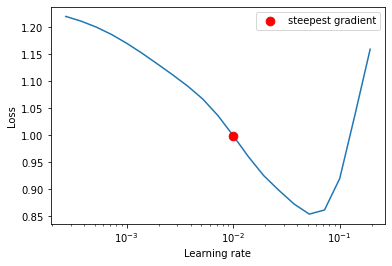

training_loss:1.11,     validation_loss:70.57
training_loss:51.50,     validation_loss:17.65
training_loss:12.83,     validation_loss:6.19
training_loss:4.53,     validation_loss:7.29
training_loss:5.32,     validation_loss:2.23
training_loss:1.69,     validation_loss:0.76
training_loss:0.64,     validation_loss:0.67
training_loss:0.58,     validation_loss:0.60
training_loss:0.53,     validation_loss:1.32
training_loss:1.01,     validation_loss:2.14
training_loss:1.63,     validation_loss:3.35
training_loss:2.48,     validation_loss:0.94
training_loss:0.76,     validation_loss:1.01
training_loss:0.80,     validation_loss:0.58
training_loss:0.49,     validation_loss:0.68
training_loss:0.56,     validation_loss:0.45
training_loss:0.39,     validation_loss:0.61
training_loss:0.54,     validation_loss:0.40
training_loss:0.36,     validation_loss:0.65
training_loss:0.61,     validation_loss:0.40
training_loss:0.37,     validation_loss:0.70
training_loss:0.67,     validation_loss:0.37
traini

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-02


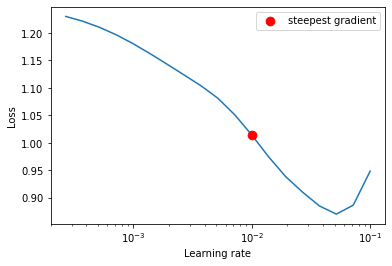

training_loss:1.12,     validation_loss:318.69
training_loss:233.03,     validation_loss:18.16
training_loss:13.18,     validation_loss:15.38
training_loss:11.16,     validation_loss:9.95
training_loss:7.19,     validation_loss:6.37
training_loss:4.77,     validation_loss:7.62
training_loss:5.52,     validation_loss:1.41
training_loss:1.29,     validation_loss:1.20
training_loss:0.91,     validation_loss:0.79
training_loss:0.74,     validation_loss:0.94
training_loss:0.70,     validation_loss:0.64
training_loss:0.61,     validation_loss:1.22
training_loss:0.85,     validation_loss:1.43
training_loss:1.23,     validation_loss:1.94
training_loss:1.37,     validation_loss:1.37
training_loss:1.21,     validation_loss:1.57
training_loss:1.11,     validation_loss:0.94
training_loss:0.83,     validation_loss:1.18
training_loss:0.83,     validation_loss:0.73
training_loss:0.65,     validation_loss:0.97
training_loss:0.69,     validation_loss:0.64
training_loss:0.57,     validation_loss:0.86
tr

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-02


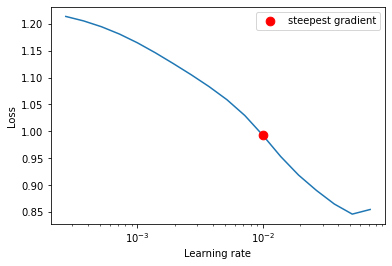

training_loss:1.11,     validation_loss:58.74
training_loss:42.85,     validation_loss:13.96
training_loss:10.15,     validation_loss:5.30
training_loss:3.90,     validation_loss:8.47
training_loss:6.20,     validation_loss:4.35
training_loss:3.21,     validation_loss:1.32
training_loss:1.03,     validation_loss:0.76
training_loss:0.65,     validation_loss:0.70
training_loss:0.56,     validation_loss:1.15
training_loss:0.94,     validation_loss:0.60
training_loss:0.53,     validation_loss:0.88
training_loss:0.82,     validation_loss:0.44
training_loss:0.41,     validation_loss:0.57
training_loss:0.54,     validation_loss:0.40
training_loss:0.37,     validation_loss:0.46
training_loss:0.43,     validation_loss:0.38
training_loss:0.34,     validation_loss:0.44
training_loss:0.40,     validation_loss:0.39
training_loss:0.35,     validation_loss:0.48
training_loss:0.45,     validation_loss:0.50
training_loss:0.47,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.49
traini

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.39E-02


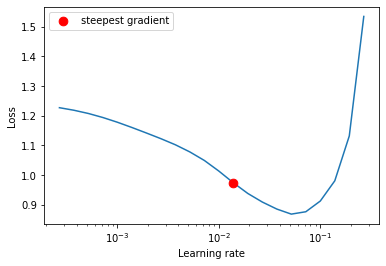

training_loss:1.12,     validation_loss:160.00
training_loss:116.91,     validation_loss:19.22
training_loss:13.87,     validation_loss:12.28
training_loss:8.84,     validation_loss:6.24
training_loss:4.46,     validation_loss:5.84
training_loss:4.43,     validation_loss:9.21
training_loss:6.66,     validation_loss:1.90
training_loss:1.59,     validation_loss:1.32
training_loss:1.12,     validation_loss:1.77
training_loss:1.29,     validation_loss:0.90
training_loss:0.83,     validation_loss:1.07
training_loss:0.81,     validation_loss:0.68
training_loss:0.61,     validation_loss:0.84
training_loss:0.63,     validation_loss:0.56
training_loss:0.48,     validation_loss:0.80
training_loss:0.64,     validation_loss:0.73
training_loss:0.67,     validation_loss:1.13
training_loss:0.98,     validation_loss:0.63
training_loss:0.57,     validation_loss:0.84
training_loss:0.68,     validation_loss:0.56
training_loss:0.49,     validation_loss:0.69
training_loss:0.54,     validation_loss:0.54
tra

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-02


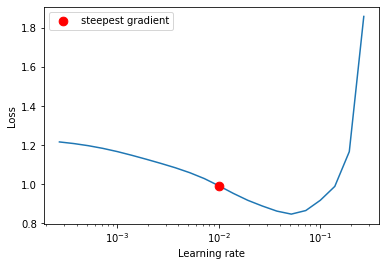

training_loss:1.11,     validation_loss:82.40
training_loss:60.17,     validation_loss:19.98
training_loss:14.52,     validation_loss:40.98
training_loss:30.03,     validation_loss:17.34
training_loss:12.60,     validation_loss:7.93
training_loss:5.73,     validation_loss:6.24
training_loss:4.67,     validation_loss:6.68
training_loss:4.85,     validation_loss:1.69
training_loss:1.34,     validation_loss:0.64
training_loss:0.54,     validation_loss:0.63
training_loss:0.54,     validation_loss:0.60
training_loss:0.51,     validation_loss:0.56
training_loss:0.48,     validation_loss:0.54
training_loss:0.46,     validation_loss:0.50
training_loss:0.44,     validation_loss:0.61
training_loss:0.47,     validation_loss:0.55
training_loss:0.48,     validation_loss:0.88
training_loss:0.63,     validation_loss:0.47
training_loss:0.42,     validation_loss:0.62
training_loss:0.50,     validation_loss:0.61
training_loss:0.57,     validation_loss:0.77
training_loss:0.69,     validation_loss:0.62
tr

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-02


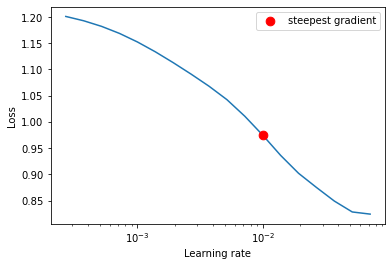

training_loss:1.11,     validation_loss:49.15
training_loss:35.84,     validation_loss:10.98
training_loss:7.99,     validation_loss:99.55
training_loss:72.86,     validation_loss:25.51
training_loss:18.57,     validation_loss:11.56
training_loss:8.38,     validation_loss:3.61
training_loss:2.58,     validation_loss:6.47
training_loss:4.85,     validation_loss:6.50
training_loss:4.75,     validation_loss:1.60
training_loss:1.29,     validation_loss:0.64
training_loss:0.60,     validation_loss:0.92
training_loss:0.71,     validation_loss:0.59
training_loss:0.55,     validation_loss:0.64
training_loss:0.53,     validation_loss:0.55
training_loss:0.49,     validation_loss:0.55
training_loss:0.47,     validation_loss:0.52
training_loss:0.45,     validation_loss:0.50
training_loss:0.42,     validation_loss:0.48
training_loss:0.41,     validation_loss:0.47
training_loss:0.39,     validation_loss:0.45
training_loss:0.39,     validation_loss:0.48
training_loss:0.38,     validation_loss:0.51
tr

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


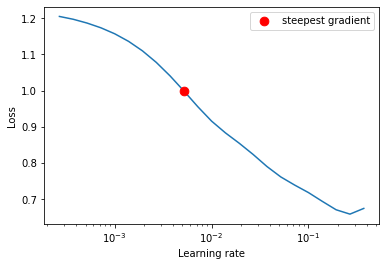

training_loss:1.11,     validation_loss:0.77
training_loss:0.76,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.62
training_loss:0.60,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.73
training_loss:0.73,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.41
training_loss:0.39,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.38
training_loss:0.35,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.36
training_loss:0.33,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.34
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


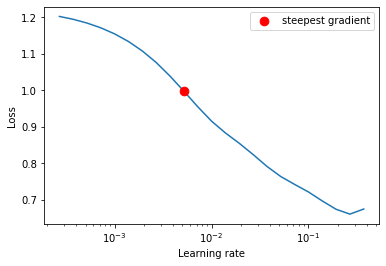

training_loss:1.11,     validation_loss:0.77
training_loss:0.76,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.47
training_loss:0.46,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.44
training_loss:0.42,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.69
training_loss:0.69,     validation_loss:0.41
training_loss:0.39,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.36
training_loss:0.33,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.34
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


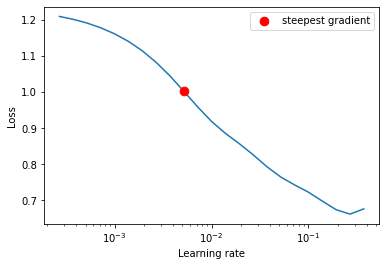

training_loss:1.11,     validation_loss:0.79
training_loss:0.78,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.73
training_loss:0.71,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.59
training_loss:0.57,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.43
training_loss:0.41,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.36
training_loss:0.34,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.34
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


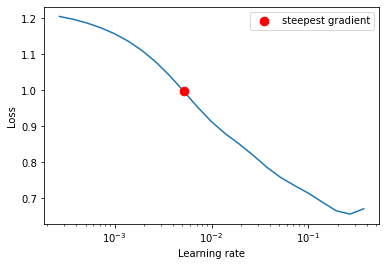

training_loss:1.10,     validation_loss:0.79
training_loss:0.77,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.63
training_loss:0.61,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.48
training_loss:0.47,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.41
training_loss:0.39,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.37
training_loss:0.35,     validation_loss:0.59
training_loss:0.57,     validation_loss:0.35
training_loss:0.32,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.33
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


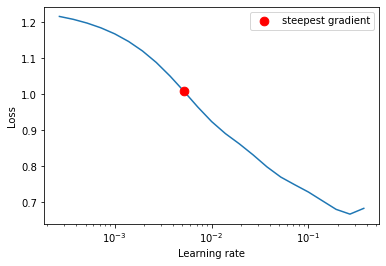

training_loss:1.11,     validation_loss:0.81
training_loss:0.79,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.49
training_loss:0.48,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.68
training_loss:0.68,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.44
training_loss:0.42,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.39
training_loss:0.37,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.37
training_loss:0.35,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.35
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


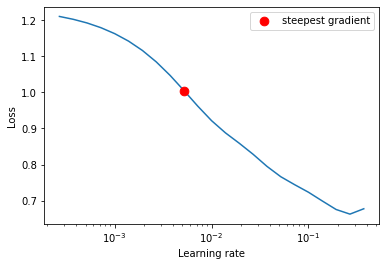

training_loss:1.11,     validation_loss:0.81
training_loss:0.80,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.65
training_loss:0.63,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.45
training_loss:0.44,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.44
training_loss:0.42,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.39
training_loss:0.36,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.36
training_loss:0.34,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.34
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


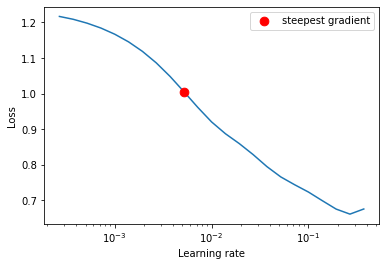

training_loss:1.11,     validation_loss:0.77
training_loss:0.76,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.47
training_loss:0.46,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.71
training_loss:0.71,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.42
training_loss:0.40,     validation_loss:0.61
training_loss:0.59,     validation_loss:0.39
training_loss:0.37,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.37
training_loss:0.34,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.34
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


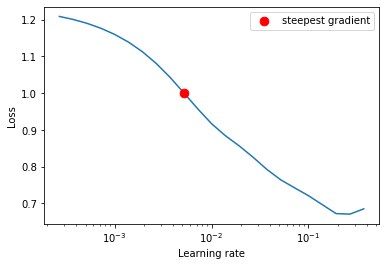

training_loss:1.11,     validation_loss:0.82
training_loss:0.81,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.66
training_loss:0.64,     validation_loss:0.58
training_loss:0.56,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.51
training_loss:0.50,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.68
training_loss:0.68,     validation_loss:0.39
training_loss:0.36,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.36
training_loss:0.33,     validation_loss:0.58
training_loss:0.56,     validation_loss:0.34
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


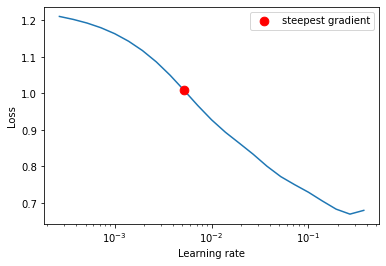

training_loss:1.11,     validation_loss:0.79
training_loss:0.78,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.71
training_loss:0.71,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.72
training_loss:0.72,     validation_loss:0.42
training_loss:0.40,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.37
training_loss:0.35,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.35
training_loss:0.32,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.33
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


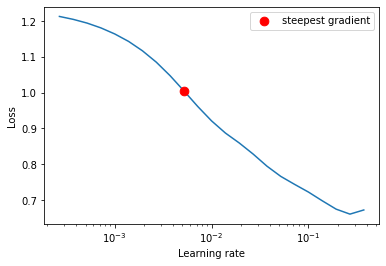

training_loss:1.11,     validation_loss:0.77
training_loss:0.76,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.71
training_loss:0.69,     validation_loss:0.61
training_loss:0.59,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.53
training_loss:0.51,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.50
training_loss:0.49,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.41
training_loss:0.39,     validation_loss:0.61
training_loss:0.59,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.36
training_loss:0.34,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.34
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


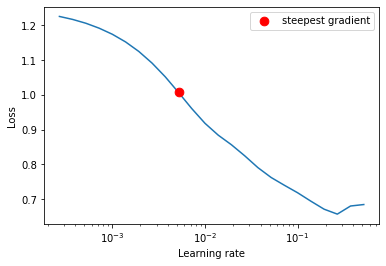

training_loss:1.12,     validation_loss:0.77
training_loss:0.76,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.61
training_loss:0.59,     validation_loss:0.53
training_loss:0.51,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.45
training_loss:0.44,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.51
training_loss:0.50,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.43
training_loss:0.41,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.39
training_loss:0.37,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.36
training_loss:0.34,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.34
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


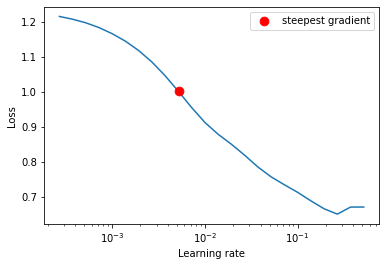

training_loss:1.11,     validation_loss:0.80
training_loss:0.79,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.50
training_loss:0.49,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.44
training_loss:0.42,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.39
training_loss:0.37,     validation_loss:0.59
training_loss:0.57,     validation_loss:0.36
training_loss:0.34,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.34
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


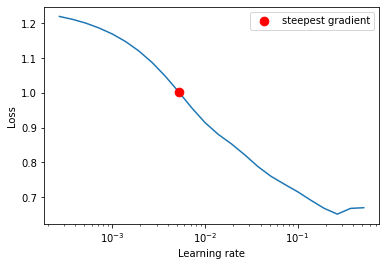

training_loss:1.11,     validation_loss:0.79
training_loss:0.78,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.48
training_loss:0.47,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.42
training_loss:0.40,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.35
training_loss:0.33,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.33
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


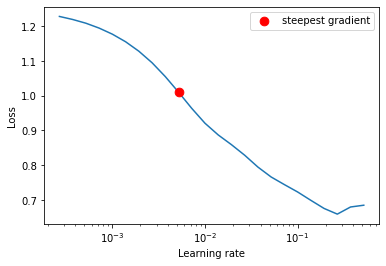

training_loss:1.11,     validation_loss:0.81
training_loss:0.80,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.65
training_loss:0.63,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.50
training_loss:0.49,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.50
training_loss:0.49,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.39
training_loss:0.37,     validation_loss:0.59
training_loss:0.57,     validation_loss:0.36
training_loss:0.34,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.34
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


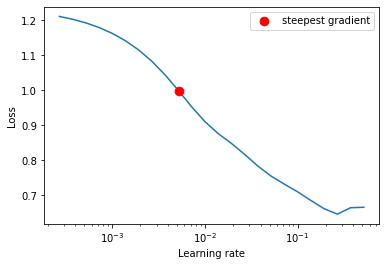

training_loss:1.12,     validation_loss:0.80
training_loss:0.79,     validation_loss:0.74
training_loss:0.72,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.64
training_loss:0.62,     validation_loss:0.64
training_loss:0.62,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.43
training_loss:0.41,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.59
training_loss:0.57,     validation_loss:0.36
training_loss:0.33,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.34
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


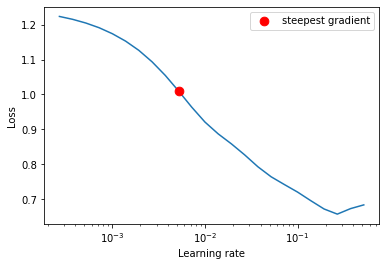

training_loss:1.12,     validation_loss:0.81
training_loss:0.80,     validation_loss:0.75
training_loss:0.73,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.65
training_loss:0.63,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.50
training_loss:0.49,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.39
training_loss:0.37,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.37
training_loss:0.34,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.35
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


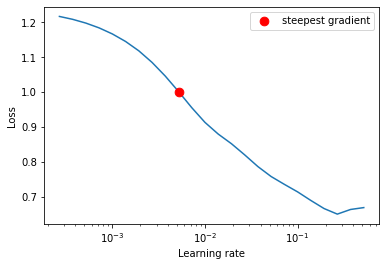

training_loss:1.11,     validation_loss:0.79
training_loss:0.78,     validation_loss:0.73
training_loss:0.71,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.63
training_loss:0.61,     validation_loss:0.63
training_loss:0.61,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.43
training_loss:0.41,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.36
training_loss:0.34,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.34
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


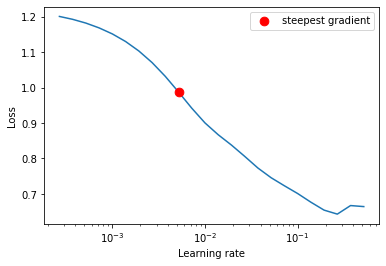

training_loss:1.10,     validation_loss:0.83
training_loss:0.82,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.76
training_loss:0.74,     validation_loss:0.67
training_loss:0.65,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.59
training_loss:0.57,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.52
training_loss:0.51,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.44
training_loss:0.43,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.39
training_loss:0.37,     validation_loss:0.62
training_loss:0.60,     validation_loss:0.36
training_loss:0.34,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.34
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


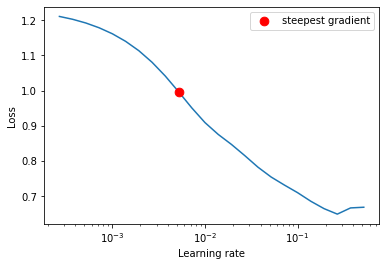

training_loss:1.11,     validation_loss:0.79
training_loss:0.78,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.63
training_loss:0.61,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.43
training_loss:0.41,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.58
training_loss:0.56,     validation_loss:0.36
training_loss:0.34,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.34
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


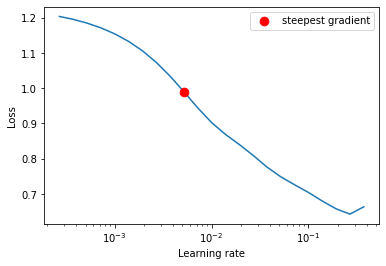

training_loss:1.11,     validation_loss:0.80
training_loss:0.79,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.47
training_loss:0.46,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.43
training_loss:0.41,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.35
training_loss:0.33,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.33
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


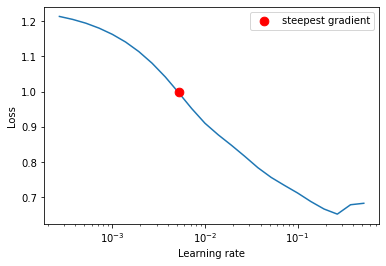

training_loss:1.11,     validation_loss:0.82
training_loss:0.81,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.74
training_loss:0.72,     validation_loss:0.65
training_loss:0.63,     validation_loss:0.65
training_loss:0.63,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.58
training_loss:0.56,     validation_loss:0.51
training_loss:0.49,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.45
training_loss:0.44,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.51
training_loss:0.49,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.40
training_loss:0.38,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.37
training_loss:0.35,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.35
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


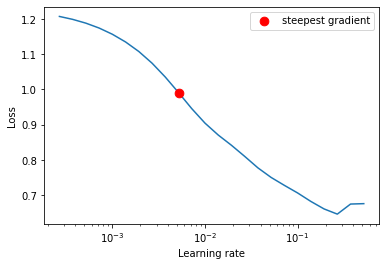

training_loss:1.11,     validation_loss:0.84
training_loss:0.82,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.67
training_loss:0.65,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.59
training_loss:0.57,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.53
training_loss:0.51,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.41
training_loss:0.39,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.37
training_loss:0.35,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.35
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


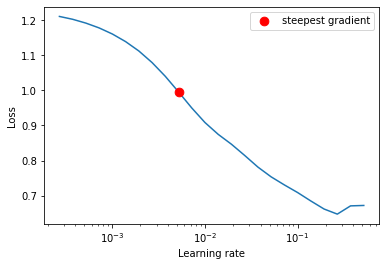

training_loss:1.11,     validation_loss:0.83
training_loss:0.82,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.75
training_loss:0.73,     validation_loss:0.66
training_loss:0.64,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.58
training_loss:0.56,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.52
training_loss:0.50,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.40
training_loss:0.38,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.37
training_loss:0.35,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.35
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


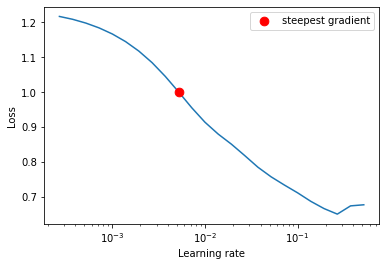

training_loss:1.11,     validation_loss:0.85
training_loss:0.84,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.68
training_loss:0.66,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.43
training_loss:0.41,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.36
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


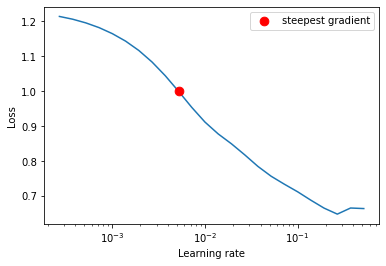

training_loss:1.11,     validation_loss:0.82
training_loss:0.81,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.65
training_loss:0.63,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.58
training_loss:0.56,     validation_loss:0.51
training_loss:0.50,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.46
training_loss:0.45,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.39
training_loss:0.37,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.36
training_loss:0.34,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.34
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


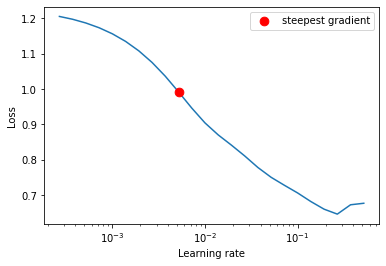

training_loss:1.11,     validation_loss:0.84
training_loss:0.83,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.68
training_loss:0.66,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.60
training_loss:0.58,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.48
training_loss:0.47,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.41
training_loss:0.39,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.37
training_loss:0.35,     validation_loss:0.58
training_loss:0.56,     validation_loss:0.35
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


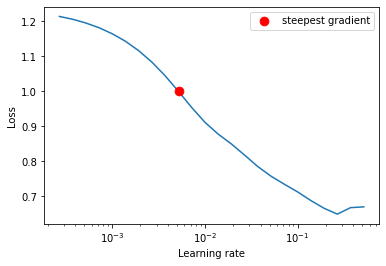

training_loss:1.11,     validation_loss:0.84
training_loss:0.83,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.67
training_loss:0.65,     validation_loss:0.67
training_loss:0.65,     validation_loss:0.59
training_loss:0.57,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.53
training_loss:0.51,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.47
training_loss:0.46,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.40
training_loss:0.38,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.37
training_loss:0.34,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.35
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


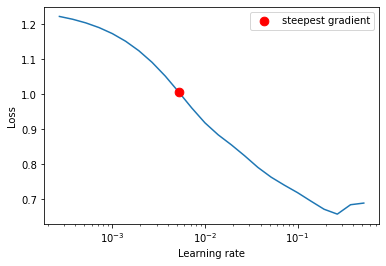

training_loss:1.12,     validation_loss:0.83
training_loss:0.82,     validation_loss:0.76
training_loss:0.74,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.67
training_loss:0.65,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.59
training_loss:0.57,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.52
training_loss:0.51,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.47
training_loss:0.46,     validation_loss:0.53
training_loss:0.51,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.42
training_loss:0.40,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.36
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


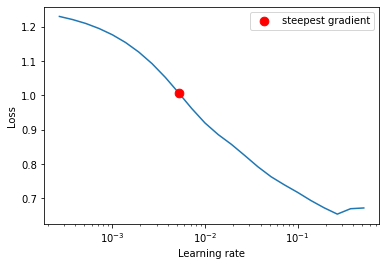

training_loss:1.12,     validation_loss:0.82
training_loss:0.80,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.65
training_loss:0.63,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.51
training_loss:0.49,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.51
training_loss:0.49,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.41
training_loss:0.39,     validation_loss:0.59
training_loss:0.57,     validation_loss:0.38
training_loss:0.35,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.36
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


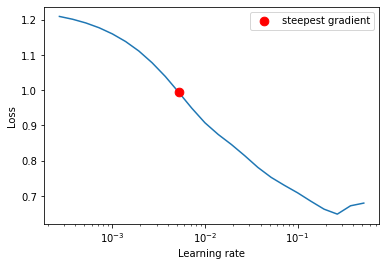

training_loss:1.11,     validation_loss:0.85
training_loss:0.84,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.60
training_loss:0.58,     validation_loss:0.60
training_loss:0.58,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.48
training_loss:0.47,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.49
training_loss:0.48,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.42
training_loss:0.40,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.36
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


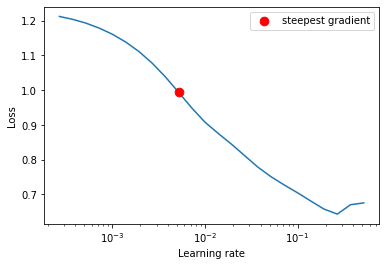

training_loss:1.11,     validation_loss:0.85
training_loss:0.83,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.70
training_loss:0.70,     validation_loss:0.44
training_loss:0.42,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.39
training_loss:0.37,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.37
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


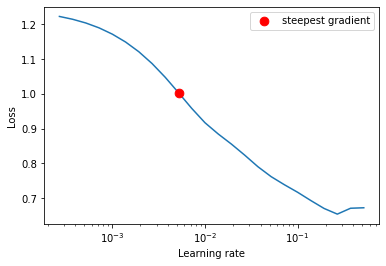

training_loss:1.12,     validation_loss:0.79
training_loss:0.78,     validation_loss:0.72
training_loss:0.70,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.63
training_loss:0.61,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.40
training_loss:0.38,     validation_loss:0.58
training_loss:0.56,     validation_loss:0.37
training_loss:0.35,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.35
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


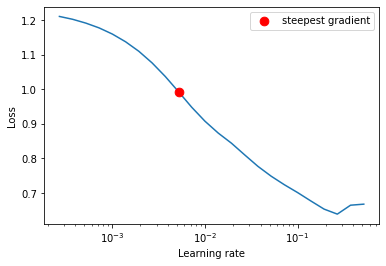

training_loss:1.11,     validation_loss:0.85
training_loss:0.84,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.42
training_loss:0.40,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.36
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


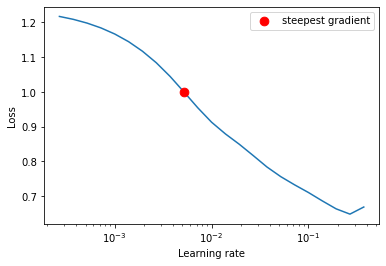

training_loss:1.11,     validation_loss:0.83
training_loss:0.82,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.52
training_loss:0.51,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.47
training_loss:0.46,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.41
training_loss:0.39,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.36
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


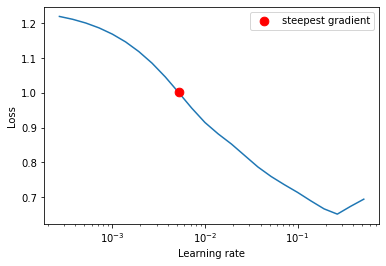

training_loss:1.12,     validation_loss:0.81
training_loss:0.79,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.51
training_loss:0.49,     validation_loss:0.53
training_loss:0.51,     validation_loss:0.46
training_loss:0.45,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.46
training_loss:0.45,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.41
training_loss:0.39,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.36
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


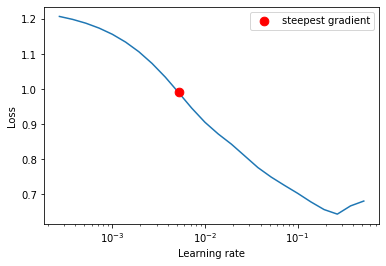

training_loss:1.11,     validation_loss:0.85
training_loss:0.84,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.68
training_loss:0.66,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.60
training_loss:0.58,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.59
training_loss:0.57,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.42
training_loss:0.40,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.38
training_loss:0.35,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.36
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


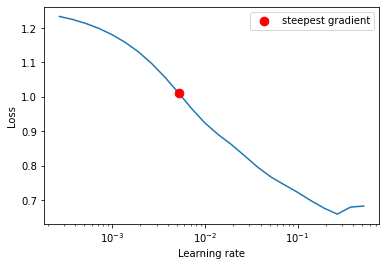

training_loss:1.12,     validation_loss:0.86
training_loss:0.84,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.76
training_loss:0.74,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.60
training_loss:0.58,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.53
training_loss:0.51,     validation_loss:0.45
training_loss:0.44,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.44
training_loss:0.42,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.39
training_loss:0.37,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.37
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


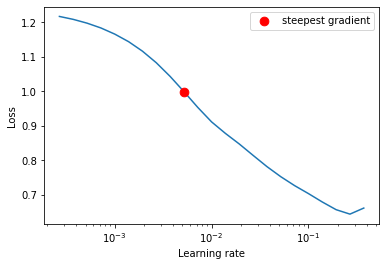

training_loss:1.11,     validation_loss:0.83
training_loss:0.82,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.67
training_loss:0.65,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.48
training_loss:0.47,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.47
training_loss:0.46,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.41
training_loss:0.39,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.38
training_loss:0.35,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.35
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


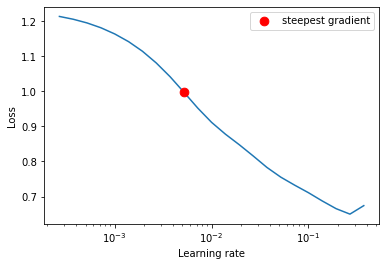

training_loss:1.11,     validation_loss:0.80
training_loss:0.79,     validation_loss:0.72
training_loss:0.70,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.50
training_loss:0.49,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.46
training_loss:0.45,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.40
training_loss:0.38,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.37
training_loss:0.35,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.35
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


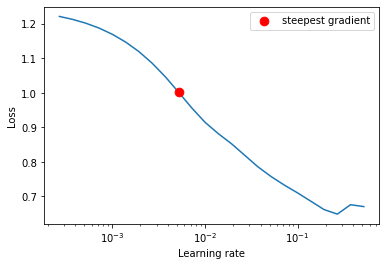

training_loss:1.11,     validation_loss:0.86
training_loss:0.85,     validation_loss:0.76
training_loss:0.74,     validation_loss:0.77
training_loss:0.76,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.69
training_loss:0.67,     validation_loss:0.62
training_loss:0.60,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.51
training_loss:0.49,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.40
training_loss:0.37,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.37
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


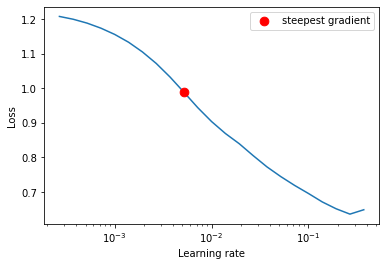

training_loss:1.11,     validation_loss:0.83
training_loss:0.82,     validation_loss:0.73
training_loss:0.71,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.59
training_loss:0.57,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.53
training_loss:0.51,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.48
training_loss:0.47,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.42
training_loss:0.40,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.36
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


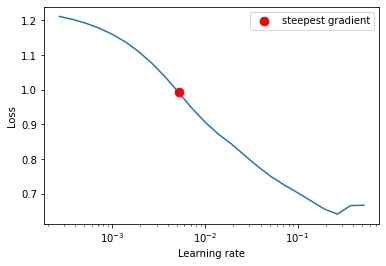

training_loss:1.11,     validation_loss:0.89
training_loss:0.88,     validation_loss:0.77
training_loss:0.76,     validation_loss:0.78
training_loss:0.77,     validation_loss:0.71
training_loss:0.69,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.63
training_loss:0.61,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.52
training_loss:0.51,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.42
training_loss:0.39,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.38
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


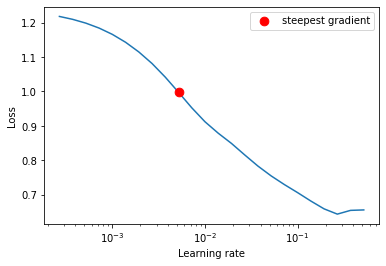

training_loss:1.11,     validation_loss:0.82
training_loss:0.81,     validation_loss:0.72
training_loss:0.71,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.65
training_loss:0.63,     validation_loss:0.58
training_loss:0.56,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.52
training_loss:0.50,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.47
training_loss:0.46,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.62
training_loss:0.60,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.41
training_loss:0.39,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.38
training_loss:0.35,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.36
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


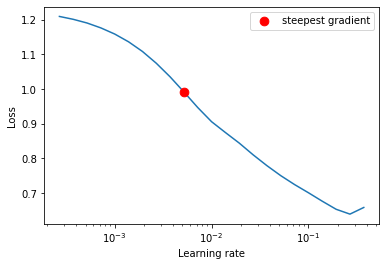

training_loss:1.11,     validation_loss:0.87
training_loss:0.86,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.77
training_loss:0.76,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.62
training_loss:0.60,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.51
training_loss:0.49,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.49
training_loss:0.48,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.40
training_loss:0.38,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.37
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


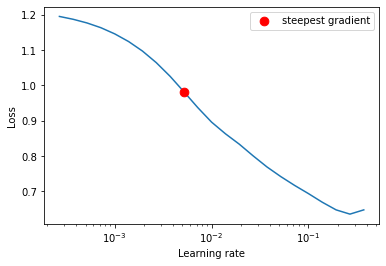

training_loss:1.11,     validation_loss:0.85
training_loss:0.84,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.68
training_loss:0.66,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.61
training_loss:0.59,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.43
training_loss:0.41,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.39
training_loss:0.36,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.36
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


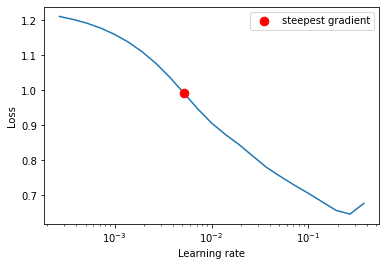

training_loss:1.11,     validation_loss:0.86
training_loss:0.85,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.62
training_loss:0.60,     validation_loss:0.61
training_loss:0.59,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.51
training_loss:0.49,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.46
training_loss:0.45,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.44
training_loss:0.42,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.39
training_loss:0.37,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.37
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


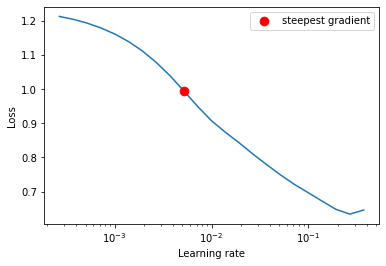

training_loss:1.11,     validation_loss:0.87
training_loss:0.86,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.77
training_loss:0.76,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.69
training_loss:0.67,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.51
training_loss:0.49,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.40
training_loss:0.38,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.37
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


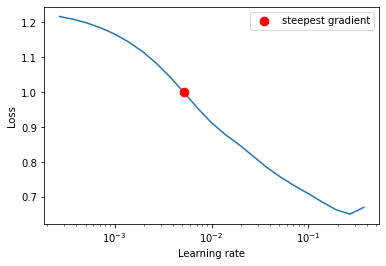

training_loss:1.12,     validation_loss:0.87
training_loss:0.86,     validation_loss:0.77
training_loss:0.76,     validation_loss:0.77
training_loss:0.76,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.52
training_loss:0.50,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.47
training_loss:0.46,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.41
training_loss:0.39,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.38
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


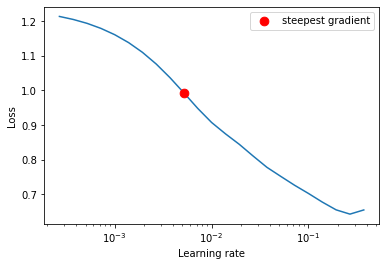

training_loss:1.11,     validation_loss:0.86
training_loss:0.85,     validation_loss:0.75
training_loss:0.73,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.69
training_loss:0.67,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.62
training_loss:0.60,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.51
training_loss:0.49,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.40
training_loss:0.38,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.37
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


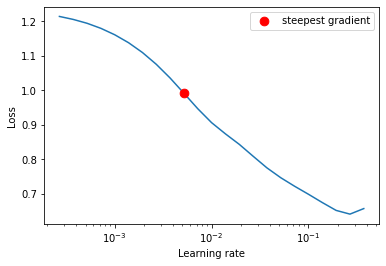

training_loss:1.11,     validation_loss:0.85
training_loss:0.84,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.44
training_loss:0.42,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.39
training_loss:0.37,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.37
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


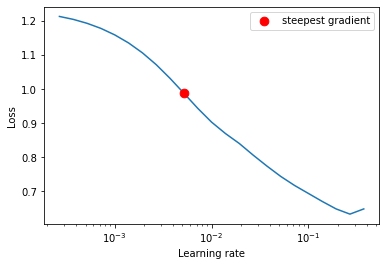

training_loss:1.11,     validation_loss:0.86
training_loss:0.85,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.68
training_loss:0.66,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.61
training_loss:0.59,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.50
training_loss:0.49,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.49
training_loss:0.48,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.40
training_loss:0.38,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.38
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


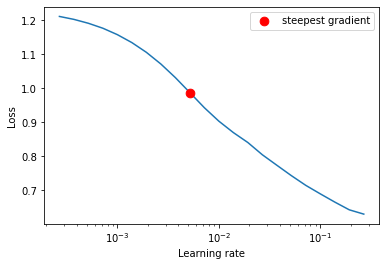

training_loss:1.11,     validation_loss:0.86
training_loss:0.85,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.69
training_loss:0.67,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.62
training_loss:0.60,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.51
training_loss:0.49,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.41
training_loss:0.38,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.38
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


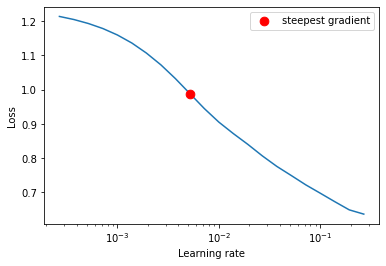

training_loss:1.11,     validation_loss:0.85
training_loss:0.84,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.68
training_loss:0.66,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.61
training_loss:0.59,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.50
training_loss:0.49,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.46
training_loss:0.45,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.44
training_loss:0.42,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.40
training_loss:0.37,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.37
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


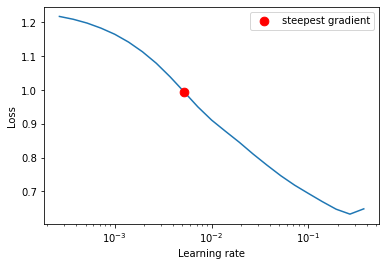

training_loss:1.12,     validation_loss:0.80
training_loss:0.79,     validation_loss:0.71
training_loss:0.70,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.65
training_loss:0.63,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.53
training_loss:0.51,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.48
training_loss:0.47,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.46
training_loss:0.45,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.42
training_loss:0.40,     validation_loss:0.60
training_loss:0.58,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.36
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


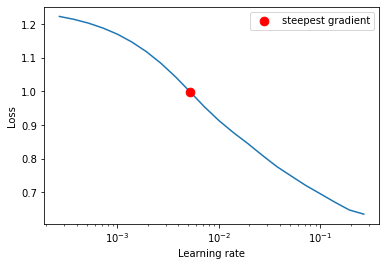

training_loss:1.11,     validation_loss:0.88
training_loss:0.87,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.77
training_loss:0.76,     validation_loss:0.70
training_loss:0.69,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.52
training_loss:0.50,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.48
training_loss:0.47,     validation_loss:0.69
training_loss:0.69,     validation_loss:0.47
training_loss:0.44,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.41
training_loss:0.39,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.38
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


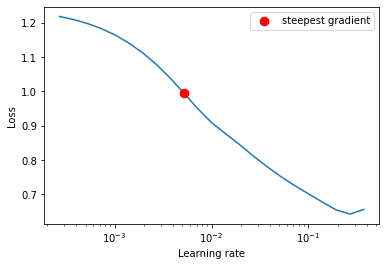

training_loss:1.11,     validation_loss:0.86
training_loss:0.85,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.76
training_loss:0.75,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.56
training_loss:0.55,     validation_loss:0.51
training_loss:0.50,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.48
training_loss:0.47,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.46
training_loss:0.43,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.41
training_loss:0.38,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.38
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


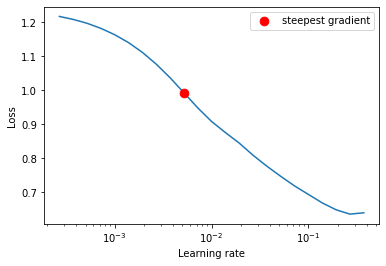

training_loss:1.12,     validation_loss:0.85
training_loss:0.84,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.67
training_loss:0.65,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.60
training_loss:0.58,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.53
training_loss:0.51,     validation_loss:0.46
training_loss:0.45,     validation_loss:0.55
training_loss:0.54,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.64
training_loss:0.63,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.45
training_loss:0.43,     validation_loss:0.63
training_loss:0.62,     validation_loss:0.40
training_loss:0.38,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.38
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


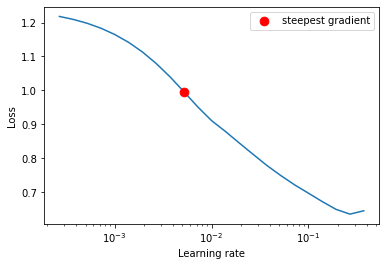

training_loss:1.12,     validation_loss:0.82
training_loss:0.81,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.66
training_loss:0.64,     validation_loss:0.59
training_loss:0.58,     validation_loss:0.59
training_loss:0.57,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.53
training_loss:0.52,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.66
training_loss:0.65,     validation_loss:0.42
training_loss:0.40,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.38
training_loss:0.36,     validation_loss:0.57
training_loss:0.56,     validation_loss:0.36
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


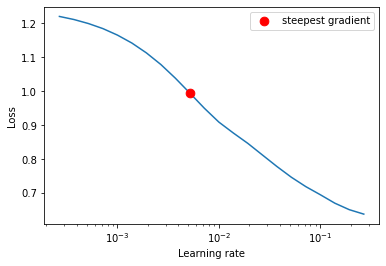

training_loss:1.11,     validation_loss:0.87
training_loss:0.86,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.77
training_loss:0.76,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.69
training_loss:0.68,     validation_loss:0.63
training_loss:0.61,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.52
training_loss:0.50,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.48
training_loss:0.46,     validation_loss:0.54
training_loss:0.53,     validation_loss:0.46
training_loss:0.44,     validation_loss:0.61
training_loss:0.60,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.68
training_loss:0.67,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.42
training_loss:0.40,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.39
training_l

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.18E-03


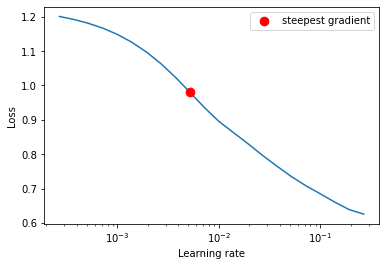

training_loss:1.10,     validation_loss:0.85
training_loss:0.84,     validation_loss:0.73
training_loss:0.72,     validation_loss:0.75
training_loss:0.74,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.60
training_loss:0.59,     validation_loss:0.55
training_loss:0.53,     validation_loss:0.56
training_loss:0.54,     validation_loss:0.50
training_loss:0.48,     validation_loss:0.54
training_loss:0.52,     validation_loss:0.47
training_loss:0.45,     validation_loss:0.57
training_loss:0.55,     validation_loss:0.47
training_loss:0.46,     validation_loss:0.65
training_loss:0.64,     validation_loss:0.49
training_loss:0.47,     validation_loss:0.67
training_loss:0.66,     validation_loss:0.44
training_loss:0.42,     validation_loss:0.62
training_loss:0.61,     validation_loss:0.40
training_loss:0.37,     validation_loss:0.58
training_loss:0.57,     validation_loss:0.37
training_l

In [40]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
for j, h in enumerate(range(1,8)):
    for k,seed in enumerate(seed_list):
        torch.manual_seed(seed)
        print("\n hidden layer = {} seed = {}" .format(h,seed))
        MSE = nn.MSELoss()
        model = My_Model(in_size, h,s,outsize,  p=0.30).to(device)
        lrfder = lrfinder(model)
        optimizer = optim.RMSprop(model.parameters(), lr=lrfder, weight_decay= 1e-3)
        total_loss= train(model, train_loader, val_loader, optimizer,epochs)
        for training_loss,validation_loss in zip(total_loss['training_loss'],total_loss['validation_loss']):
            print('training_loss:{:.2f},     validation_loss:{:.2f}'.format(training_loss,validation_loss))
        r2_score[j,k] = r2score(model)
        torch.save(model.state_dict(), '/home/sneha/Downloads/files/Hemispherical/Model properties/model_{}_{}.ckpt'.format(h,seed))
        torch.cuda.empty_cache()
end.record()
torch.cuda.synchronize()
print("time taken to run this program is {:0.4f} seconds" .format(start.elapsed_time(end)))
torch.cuda.empty_cache()


[[0.69669487 0.7903958  0.90640105 0.77816159 0.85826108 0.60871171
  0.89868661 0.76361402 0.85587925 0.78733062]
 [0.90901339 0.90946487 0.91538265 0.91986975 0.92010298 0.92660343
  0.90196516 0.9303415  0.92252688 0.90139972]
 [0.88841947 0.91950694 0.91335141 0.91998946 0.92008893 0.91994851
  0.91250855 0.93112526 0.91256715 0.91631788]
 [0.91951672 0.92610842 0.92524449 0.92447749 0.92671475 0.92735453
  0.92872981 0.91930584 0.91681657 0.92367929]
 [0.92116075 0.91476637 0.92531972 0.92099654 0.91330653 0.9276119
  0.91946363 0.92614168 0.91597426 0.91887808]
 [0.92238083 0.9150671  0.92073404 0.91910749 0.92559638 0.92292271
  0.91847845 0.91581168 0.9199459  0.92106297]
 [0.91659207 0.91516568 0.92213195 0.91707991 0.91880329 0.91750853
  0.91713246 0.92325876 0.91184433 0.9203292 ]]


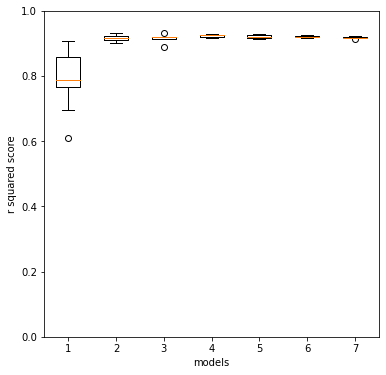

In [42]:
torch.save(r2_score, "/home/sneha/Downloads/files/Hemispherical/Model properties/Rscore1.pt")

r2_score = torch.load("/home/sneha/Downloads/files/Hemispherical/Model properties/Rscore1.pt")
print(r2_score)
fig = plt.figure(figsize=(6,6))
r=[]
for i in range(7):
        r.append(r2_score[i][:])
    
plt.ylim(ymin=0, ymax=1)
plt.boxplot(r)
plt.xlabel('models')
plt.ylabel('r squared score')
plt.show()



### Single model with optuna suggested inputs

In [43]:
epochs = 60
in_size = 3 
outsize = 14943
h = 7
s = 912
torch.manual_seed(9999)
MSE = nn.MSELoss()
model = My_Model(in_size, h,s,outsize, p=0.3).to(device)
print(model)
optimizer = optim.RMSprop(model.parameters(), lr=0.00609) # weight_decay= 1e-3
total_loss= train(model,train_loader, val_loader, optimizer, epochs)
for training_loss,validation_loss in zip(total_loss['training_loss'],total_loss['validation_loss']):
    print('training_loss:{:.2f},     validation_loss:{:.2f}'.format(training_loss,validation_loss))

if torch.cuda.is_available():
    torch.cuda.empty_cache()


[3, 912, 912, 912, 912, 912, 912, 912, 14943]
My_Model(
  (hidden): ModuleList(
    (0): Linear(in_features=3, out_features=912, bias=True)
    (1): Linear(in_features=912, out_features=912, bias=True)
    (2): Linear(in_features=912, out_features=912, bias=True)
    (3): Linear(in_features=912, out_features=912, bias=True)
    (4): Linear(in_features=912, out_features=912, bias=True)
    (5): Linear(in_features=912, out_features=912, bias=True)
    (6): Linear(in_features=912, out_features=912, bias=True)
    (7): Linear(in_features=912, out_features=14943, bias=True)
  )
  (drop): Dropout(p=0.3, inplace=False)
  (norm): BatchNorm1d(912, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
training_loss:1.11,     validation_loss:0.74
training_loss:0.73,     validation_loss:0.41
training_loss:0.39,     validation_loss:0.30
training_loss:0.27,     validation_loss:0.27
training_loss:0.24,     validation_loss:0.26
training_loss:0.23,     validation_loss:0.25
training_loss:0.2

### Saving the model and printing R2 score

In [44]:
r =torch.as_tensor(r2score(model))
torch.save(r, "./Rscore.pt")
loaded = torch.load("./Rscore.pt")
torch.save(model.state_dict(), './model_{}.ckpt'.format(h))
# model = My_Model(in_size, h,s,outsize, p=0.2)
# model.load_state_dict(torch.load('./model_{}.ckpt'.format(h)))


R squared score is tensor(0.9476, device='cuda:0')


### Predicting output

In [46]:
# x = torch.tensor([[240000,  0.100000,  45.000000],[124271.08430,  0.113554,  61.656627]]).to(device)
x = data[:][0].to(device)
yhat = model(x)

x1 = yhat[:,0:4981]
y1 = yhat[:,4981:9962]
z1 = yhat[:,9962:14943]
z1.shape

torch.Size([249, 4981])

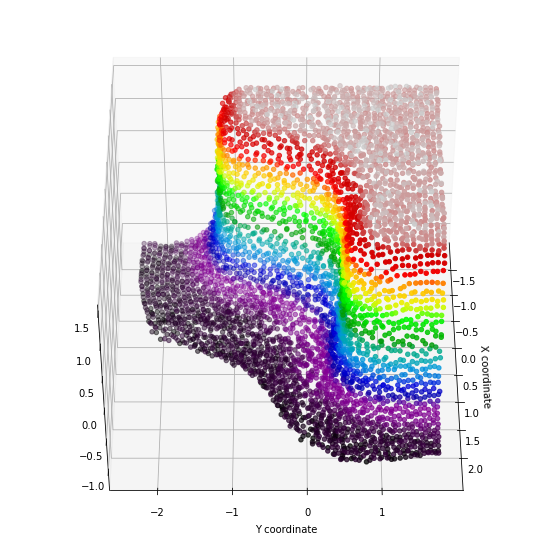

In [47]:
exp = 20

fig = plt.figure(figsize=(10,10))
xi = x1[exp,:].cpu().detach().numpy()
yi = y1[exp,:].cpu().detach().numpy()
zi = z1[exp,:].cpu().detach().numpy()
ax = fig.add_subplot(projection='3d')
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
ax.scatter3D(xi, yi, zi, c=zi, cmap='nipy_spectral')
ax.view_init(elev=45,azim=0)
plt.show()


In [ ]:
surrogate model vs model instead of optuna

In [ ]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


In [ ]:
NORMALISE DATA +
optuna look into the model 
and the range of parameter why
predict geometery according to the output + 
orgnal vs the output plot +

add different views 
normalisation view+
test sets parameters 
documentation of arriavial of output  eg how lr range
low f_press


### Optuna  workings
https://www.analyticsvidhya.com/blog/2020/11/hyperparameter-tuning-using-optuna/#:~:text=Optuna%20is%20a%20software%20framework,%2C%20bayesian%2C%20and%20evolutionary%20algorithms.